<a href="https://colab.research.google.com/github/SeyfGoumeida/PFE/blob/main/PFE_M%C3%A9moire_Master_2_MLSD_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mémoire

# Packages

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.cluster import KMeans
import gspread
import pandas as pd
import matplotlib.pyplot as plt
import csv
from datetime import datetime
#--------------------------------
import warnings
warnings.filterwarnings("ignore")
sns.set(rc ={'figure.figsize':(10,6)})
#--------------------------------
from google.colab import drive
drive.mount('/content/drive')

# Data :

## Loading data :

In [28]:
link = "/content/drive/MyDrive/PFE/AttenteEnCaisse.csv"
AttenteEnCaisse                = pd.read_csv(link, sep=",")
#---------------------------------------------------
link = "/content/drive/MyDrive/PFE/BaseMagasin.csv"
BaseMagasin = pd.read_csv(link, sep=";",encoding='latin-1')
BaseMagasin = BaseMagasin.drop(BaseMagasin.index[0])
#---------------------------------------------------
AttenteEnCaisse = AttenteEnCaisse.astype({"stoanabelkey": int})
BaseMagasin =BaseMagasin.astype({"CADANA : Anabel": int})
#-----------------        Merge the two dataframes in one dataframe     ---------------------------------------
BDDtmp = pd.merge(AttenteEnCaisse,BaseMagasin,how='left',left_on=['stoanabelkey'],right_on=['CADANA : Anabel'])
BDDtmp.drop(["Statut","Nom d'usage","Id magasin","CADANA : Anabel","Date ouverture public","Date fermeture public"],inplace=True,axis=1)
#------------------       fix column types and add Scoring Column        --------------------------------------
BDDtmp = BDDtmp.astype({"Nombre Caisses (hors SCO et périphéries)": int,'Nombre total de Caisses SCO': int,"Heure": str,"stoanabelkey": int}) 
BDDtmp["Scoring"]=0.0
BDDtmp

,stoanabelkey,stodisplaydesc,Jour,creationDate,Heure,Caisses_Prevues,Caisses_Planifiees,Ecart_en_Nb_de_Caisses,Prevues_en_H,Planifiees_en_H,...,postcode,geoX,geoY,Surface de Vente,Cluster,Cluster Profil de Clientèle,Magasin Saisonnier,Nombre Caisses (hors SCO et périphéries),Nombre total de Caisses SCO,Scoring
0,7880,MIRECOURT,Jeudi,2021-11-02,08:30:00,1,2,1,0.25,0.50,...,88500.0,6.131070,48.303820,000002000,Ruraux,Dynamique,NaN,10,0,0.0
1,7880,MIRECOURT,Jeudi,2021-11-02,08:45:00,1,3,2,0.25,0.75,...,88500.0,6.131070,48.303820,000002000,Ruraux,Dynamique,NaN,10,0,0.0
2,7880,MIRECOURT,Jeudi,2021-11-02,09:00:00,2,3,1,0.50,0.75,...,88500.0,6.131070,48.303820,000002000,Ruraux,Dynamique,NaN,10,0,0.0
3,7880,MIRECOURT,Jeudi,2021-11-02,09:15:00,2,3,1,0.50,0.75,...,88500.0,6.131070,48.303820,000002000,Ruraux,Dynamique,NaN,10,0,0.0
4,7880,MIRECOURT,Jeudi,2021-11-02,09:30:00,2,3,1,0.50,0.75,...,88500.0,6.131070,48.303820,000002000,Ruraux,Dynamique,NaN,10,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232074,6865,PARIS -SEVRES 42,Dimanche,2022-03-20,12:45:00,8,8,0,2.00,2.00,...,75007.0,2.321171,48.848785,000002360,Centre Urbain,Urbain premium,NaN,13,9,0.0
1232075,7583,PARIS -ST MARCEL,Dimanche,2022-03-20,12:45:00,3,7,4,0.75,1.75,...,75013.0,2.354026,48.837487,000001345,Centre Urbain,Urbain premium,NaN,13,6,0.0
1232076,7805,RUBELLES,Dimanche,2022-03-20,12:45:00,1,6,5,0.25,1.50,...,77950.0,2.672130,48.552070,000002374,Grands magasins de périphérie,Dynamique,NaN,13,4,0.0
1232077,7567,RUEIL MALM -COLMAR,Dimanche,2022-03-20,12:45:00,9,10,1,2.25,2.50,...,92500.0,2.179848,48.886030,000002000,Centre Urbain,Urbain pratique,NaN,12,0,0.0


## Prétraitement des données :

Type of markets depending on it's location ( city center, company... ):
Cluster Profil de Clientèle :
- 'Centre Urbain'
- 'Petit Centre-Ville'
- 'Banlieue Résidentielle'
- 'Ruraux'
- 'Grands magasins de périphérie'

In [29]:
print(list(set(BDDtmp["Cluster"].values)))
BDDtmp = BDDtmp.replace("Centre Urbain", 1)
BDDtmp = BDDtmp.replace("Petit Centre-Ville", 2)
BDDtmp = BDDtmp.replace("Banlieue Résidentielle", 3)
BDDtmp = BDDtmp.replace("Ruraux", 4)
BDDtmp = BDDtmp.replace("Grands magasins de périphérie", 5)
print(list(set(BDDtmp["Cluster"].values)))

['Grands magasins de périphérie', 'Ruraux', 'Banlieue Résidentielle', 'Petit Centre-Ville', 'Centre Urbain']
[1, 2, 3, 4, 5]


Cluster Profil de Clientèle :
- 'Dynamique'
- 'Urbain premium'
- 'Urbain pratique'
- 'Malin'

In [30]:
print(list(set(BDDtmp["Cluster Profil de Clientèle"].values)))
BDDtmp = BDDtmp.replace("Dynamique", 1)
BDDtmp = BDDtmp.replace("Urbain premium", 2)
BDDtmp = BDDtmp.replace("Urbain pratique", 3)
BDDtmp = BDDtmp.replace("Malin", 4)
print(list(set(BDDtmp["Cluster Profil de Clientèle"].values)))

['Urbain pratique', 'Dynamique', 'Malin', 'Urbain premium']
[1, 2, 3, 4]


Magasin Saisonnier :
- 'Nan'
- 'Saisonnier été'
- 'Saisonnier été-hiver'

In [31]:
print(list(set(BDDtmp["Magasin Saisonnier"].values)))
BDDtmp['Magasin Saisonnier'] = BDDtmp['Magasin Saisonnier'].fillna(0)
BDDtmp = BDDtmp.replace("saisonnier été", 1)
BDDtmp = BDDtmp.replace("saisonnier été-hiver", 2)
print(list(set(BDDtmp["Magasin Saisonnier"].values)))

[nan, 'saisonnier été-hiver', 'saisonnier été']
[0, 1, 2]


## Passage Clients : 

In [42]:
#----------------------------------------------------------------
link = "/content/drive/MyDrive/PFE/WEX/passageClientWexFinale.csv"
BDDtmpNbClient = pd.read_csv(link, sep=",",encoding='latin-1')
BDDtmpNbClient = BDDtmpNbClient.drop(columns=['Unnamed: 0'])
#----------------------------------------------------------------
BDDtmpNbClient =BDDtmpNbClient.astype({"stoAnabelKey": int,"hour": str})
#----------------------------------------------------------------
BDDtmpNbClient= BDDtmpNbClient.rename(columns={"creationDate": "date"})
BDDtmp1 = pd.merge(BDDtmp,BDDtmpNbClient,how='left',left_on=['stoanabelkey','creationDate','Heure'],right_on=['stoAnabelKey',"date","hour"])

filepath = "/content/drive/MyDrive/PFE/BDD.csv"
BDDtmp1.to_csv(filepath) 
BDDtmp1

,stoanabelkey,stodisplaydesc,Jour_x,creationDate,Heure,Caisses_Prevues,Caisses_Planifiees,Ecart_en_Nb_de_Caisses,Prevues_en_H,Planifiees_en_H,...,Scoring,stoAnabelKey,Magasin,date,Jour_y,hour,nb_caisses_tradi,nb_caisses_SCO,nb_client_trad,nb_client_sco
0,7880,MIRECOURT,Jeudi,2021-11-02,08:30:00,1,2,1,0.25,0.50,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7880,MIRECOURT,Jeudi,2021-11-02,08:45:00,1,3,2,0.25,0.75,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7880,MIRECOURT,Jeudi,2021-11-02,09:00:00,2,3,1,0.50,0.75,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7880,MIRECOURT,Jeudi,2021-11-02,09:15:00,2,3,1,0.50,0.75,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7880,MIRECOURT,Jeudi,2021-11-02,09:30:00,2,3,1,0.50,0.75,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232074,6865,PARIS -SEVRES 42,Dimanche,2022-03-20,12:45:00,8,8,0,2.00,2.00,...,0.0,6865.0,Market Paris SÃÂ¨vres,2022-03-20,Dimanche,12:45:00,5.0,9.0,18.0,25.0
1232075,7583,PARIS -ST MARCEL,Dimanche,2022-03-20,12:45:00,3,7,4,0.75,1.75,...,0.0,7583.0,Market Paris Saint-Marcel,2022-03-20,Dimanche,12:45:00,4.0,6.0,17.0,15.0
1232076,7805,RUBELLES,Dimanche,2022-03-20,12:45:00,1,6,5,0.25,1.50,...,0.0,7805.0,Market Rubelles,2022-03-20,Dimanche,12:45:00,1.0,0.0,1.0,0.0
1232077,7567,RUEIL MALM -COLMAR,Dimanche,2022-03-20,12:45:00,9,10,1,2.25,2.50,...,0.0,7567.0,Market Rueil-Malmaison Colmar,2022-03-20,Dimanche,12:45:00,9.0,0.0,52.0,0.0


In [43]:
BDD = BDDtmp1.dropna()
#----------------------------------------
BDD = BDD.reset_index()
BDD = BDD.drop(['index'], axis=1)
BDD = BDD.drop(columns=["stoAnabelKey","Magasin","date","Jour_y","hour"])
#----------------------------------------
filepath = "/content/drive/MyDrive/PFE/BDDFinale.csv"
BDD.to_csv(filepath) 
BDD

,stoanabelkey,stodisplaydesc,Jour_x,creationDate,Heure,Caisses_Prevues,Caisses_Planifiees,Ecart_en_Nb_de_Caisses,Prevues_en_H,Planifiees_en_H,...,Scoring,stoAnabelKey,Magasin,date,Jour_y,hour,nb_caisses_tradi,nb_caisses_SCO,nb_client_trad,nb_client_sco
0,8285,BRIANCON,Lundi,2022-02-14,08:00:00,1,2,1,0.25,0.50,...,0.0,8285.0,Market BrianÃÂ§on,2022-02-14,Lundi,08:00:00,2.0,0.0,8.0,0.0
1,8627,CANNES LA BOCCA,Lundi,2022-02-14,08:00:00,1,1,0,0.25,0.25,...,0.0,8627.0,Market Cannes La Bocca,2022-02-14,Lundi,08:00:00,1.0,0.0,5.0,0.0
2,7709,DAVEZIEUX,Lundi,2022-02-14,08:00:00,1,1,0,0.25,0.25,...,0.0,7709.0,Market Davezieux,2022-02-14,Lundi,08:00:00,1.0,0.0,5.0,0.0
3,7861,GARDANNE PAYANNET,Lundi,2022-02-14,08:00:00,1,2,1,0.25,0.50,...,0.0,7861.0,Market Gardanne Payannet,2022-02-14,Lundi,08:00:00,2.0,1.0,3.0,1.0
4,7998,MEZE,Lundi,2022-02-14,08:00:00,1,1,0,0.25,0.25,...,0.0,7998.0,Market Meze,2022-02-14,Lundi,08:00:00,1.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299720,7730,VINCENNES,Dimanche,2022-03-20,12:30:00,4,5,1,1.00,1.25,...,0.0,7730.0,Market Vincennes,2022-03-20,Dimanche,12:30:00,3.0,3.0,10.0,3.0
299721,7820,VOISINS LE BRETONNEU,Dimanche,2022-03-20,12:30:00,10,11,1,2.50,2.75,...,0.0,7820.0,Market Voisins-Le-Bretonneux,2022-03-20,Dimanche,12:30:00,8.0,0.0,11.0,0.0
299722,7735,BORDEAUX -V.HUGO,Dimanche,2022-03-20,12:45:00,3,6,3,0.75,1.50,...,0.0,7735.0,Market Bordeaux Hugo,2022-03-20,Dimanche,12:45:00,3.0,2.0,8.0,4.0
299723,7575,FONTENAY AUX ROSES,Dimanche,2022-03-20,12:45:00,4,5,1,1.00,1.25,...,0.0,7575.0,Market Fontenay-Aux-Roses,2022-03-20,Dimanche,12:45:00,3.0,3.0,14.0,11.0


## WEX (Nb Client / Jour) : 


this cell is used to generate the "Passage Client" DataFrame and store it i

In [ ]:
# wex=[]
# cmp=0
# # Wex du mois de fevrier
# for i in range(14,28):
#   link = "/content/drive/MyDrive/PFE/WEX/Février/WEX"+str(i)+"022022.csv"
#   wex.append( pd.read_csv(link, sep=";",header=None,encoding='latin-1'))
#   cmp+=1
# # Wex du mois de mars
# for i in range(1,32):
#   if (i<10):
#     link = "/content/drive/MyDrive/PFE/WEX/Mars/WEX0"+str(i)+"032022.csv"
#   else:
#     link = "/content/drive/MyDrive/PFE/WEX/Mars/WEX"+str(i)+"032022.csv"
#   wex.append( pd.read_csv(link, sep=";",header=None,encoding='latin-1'))
#   cmp+=1
# # Wex du mois d'avril
# for i in range(1,25):
#   if (i<10):
#     link = "/content/drive/MyDrive/PFE/WEX/Avril/WEX0"+str(i)+"042022.csv"
#   else:
#     link = "/content/drive/MyDrive/PFE/WEX/Avril/WEX"+str(i)+"042022.csv"
#   wex.append( pd.read_csv(link, sep=";",header=None,encoding='latin-1'))
#   cmp+=1
# print(cmp)
# for i in range(0,cmp):
#   wex[i]["stoAnabelKey"] = wex[i][1]
#   wex[i]["Magasin"] = wex[i][2]
#   wex[i]["creationDate"] = wex[i][3]
#   wex[i]["Jour"] = wex[i][4]
#   wex[i]["hour"] = wex[i][5]
#   wex[i]["nb_caisses_tradi"]=wex[i][14]
#   wex[i]["nb_caisses_SCO"]=wex[i][23]
#   wex[i]["nb_client_trad"]=wex[i][6]+wex[i][7]+wex[i][8]+wex[i][9]+wex[i][10]+wex[i][11]+wex[i][12]+wex[i][13]
#   wex[i]["nb_client_sco"]= wex[i][15]+wex[i][16]+wex[i][17]+wex[i][18]+wex[i][19]+wex[i][20]+wex[i][21]+wex[i][22]
#   wex[i] = wex[i].drop(columns=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
  
# passageClient = pd.concat(wex)
# passageClient= passageClient.reset_index()
# passageClient.drop(columns=['index'],inplace=True)
# filepath = "/content/drive/MyDrive/PFE/WEX/passageClientWexTMP.csv"
# passageClient.to_csv(filepath)  

# # Read the new file with the same date format then change it' date format to match the first BDDtmp
# link = "/content/drive/MyDrive/PFE/WEX/passageClientWex.csv"
# BDDtmpNbClient = pd.read_csv(link, sep=",",encoding='latin-1')
# BDDtmpNbClient = BDDtmpNbClient.drop(columns=['Unnamed: 0'])
# BDDtmpNbClient

# #date format
# from datetime import datetime
# for k in range(0,len(BDDtmpNbClient[['Magasin']])):
#   date = datetime.strptime(str(BDDtmpNbClient.at[k, "creationDate"]),'%d/%m/%Y')	
#   date = datetime.strptime(str(date),"%Y-%m-%d %H:%M:%S").strftime('%Y-%m-%d')
#   BDDtmpNbClient.at[k, "creationDate"] = date

In [48]:
passageClient = BDDtmpNbClient
# Group by Day : 
passageClient = passageClient.groupby(["date","stoAnabelKey","Magasin","Jour"]).sum().sort_values(by=['nb_client_trad'], ascending=False).reset_index()
passageClient

# Les magasins Integrés :
list_anabel=sorted(list(set(BDDtmp["stoanabelkey"].values)))
passageClientIntegre = passageClient[passageClient['stoAnabelKey'].isin(list_anabel)]
passageClientIntegre

,date,stoAnabelKey,Magasin,Jour,nb_caisses_tradi,nb_caisses_SCO,nb_client_trad,nb_client_sco
5,2022-03-05,7631,Market Clermont-Ferrand Jaude,Samedi,391,186,2910,955
6,2022-03-26,7631,Market Clermont-Ferrand Jaude,Samedi,373,186,2821,905
7,2022-04-16,7777,Market Epinay-Sur-Orge,Samedi,602,249,2808,952
8,2022-04-16,7761,Market Melun,Samedi,330,0,2806,0
10,2022-04-09,7777,Market Epinay-Sur-Orge,Samedi,607,235,2742,919
...,...,...,...,...,...,...,...,...
70378,2022-04-03,7547,Market Scheibenhard,Dimanche,0,0,0,0
70379,2022-04-03,7524,Market Toulouse Compans,Dimanche,0,0,0,0
70425,2022-04-03,8622,Market Ennery,Dimanche,0,0,0,0
70446,2022-04-03,8632,Market Pont Audemer Europe,Dimanche,0,0,0,0


-----------------     0     -----------------
----        Market Paris Jean Jaures      ------------


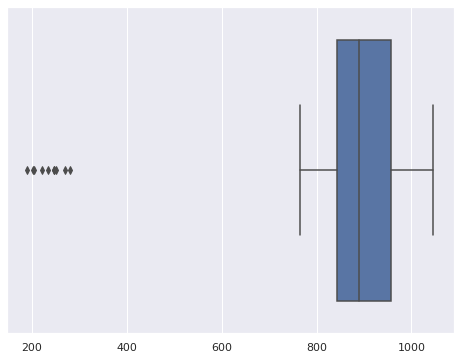

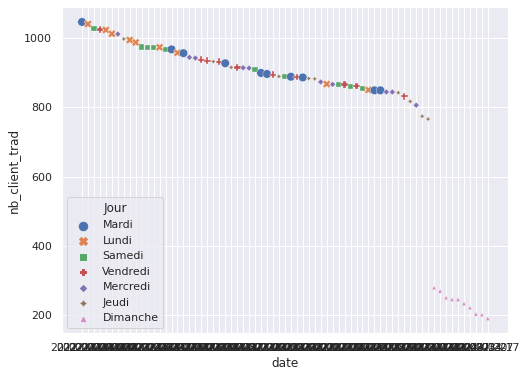

-----------------------------------------------

-----------------     1     -----------------
----        Market Bonneval Louveterie      ------------


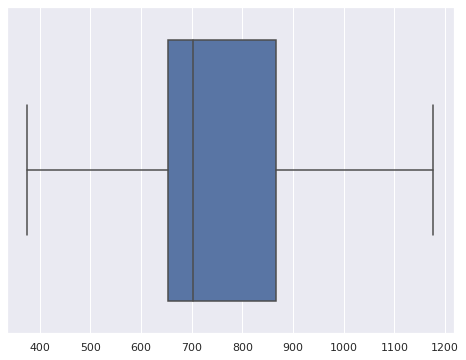

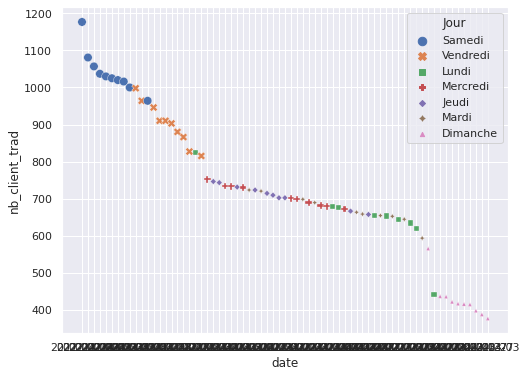

-----------------------------------------------

-----------------     2     -----------------
----        Market Massy Grand Ouest      ------------


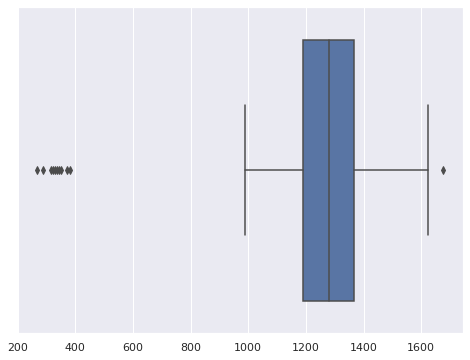

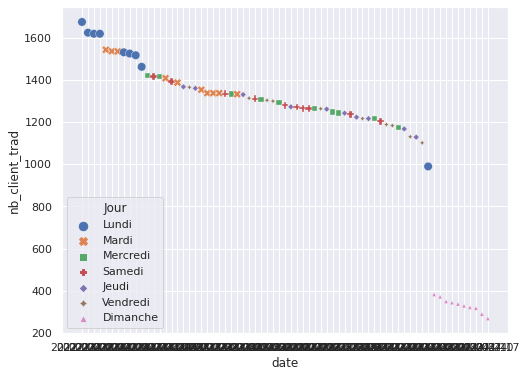

-----------------------------------------------

-----------------     3     -----------------
----        Market Paris SÃÂ¨vres      ------------


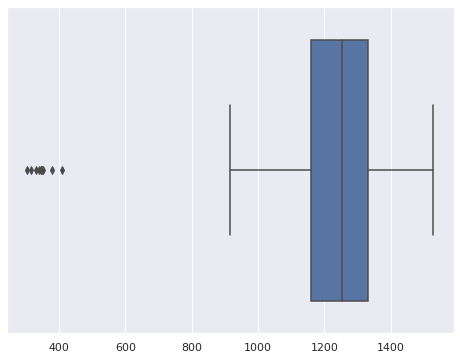

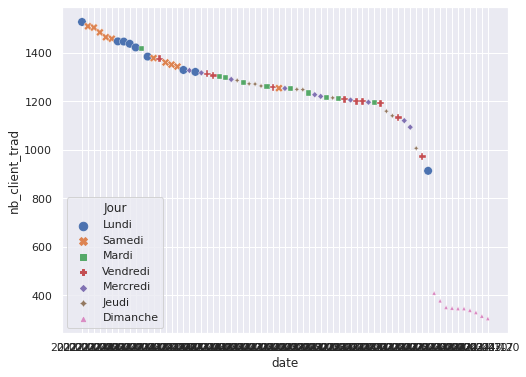

-----------------------------------------------

-----------------     4     -----------------
----        Market GÃÂ©vezÃÂ©      ------------


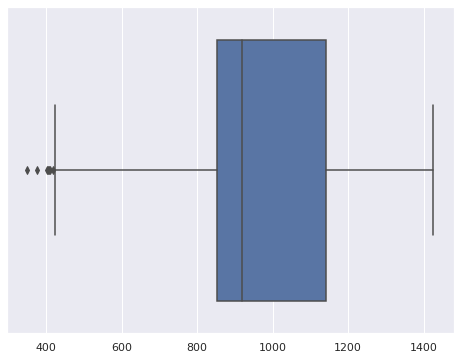

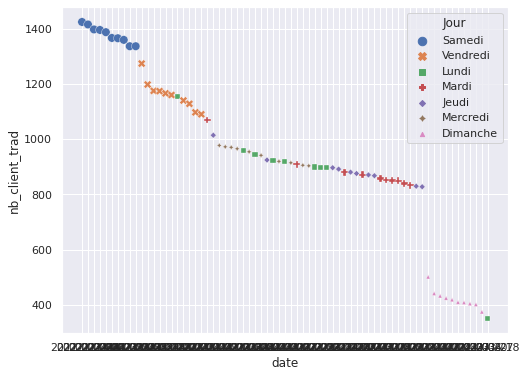

-----------------------------------------------

-----------------     5     -----------------
----        Market Rennes Bourg L'evÃÂªque      ------------


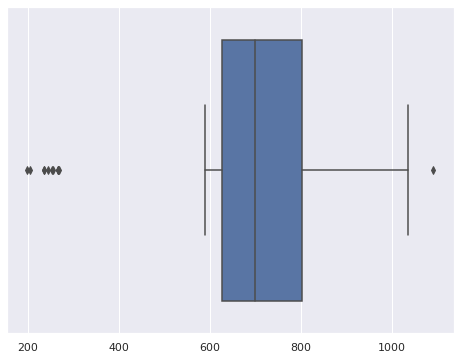

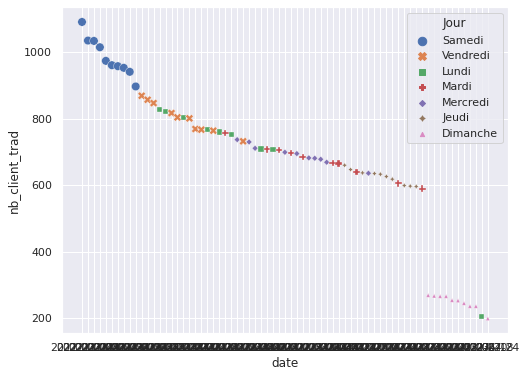

-----------------------------------------------

-----------------     6     -----------------
----        Market Vannes Tohannic      ------------


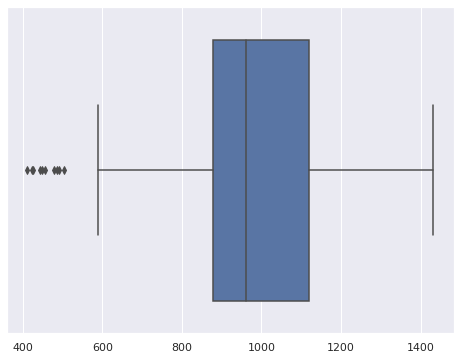

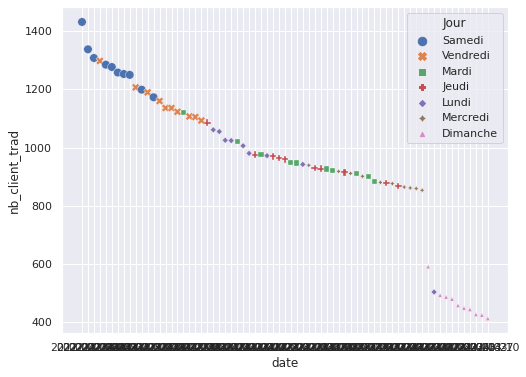

-----------------------------------------------

-----------------     7     -----------------
----        Market Amberieu-En-Bugey      ------------


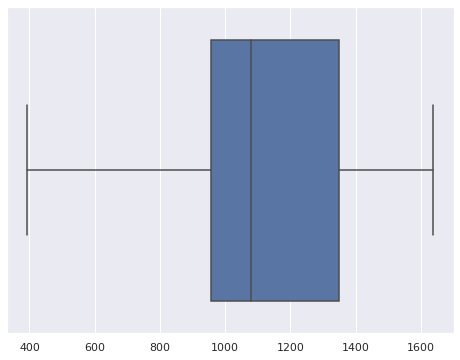

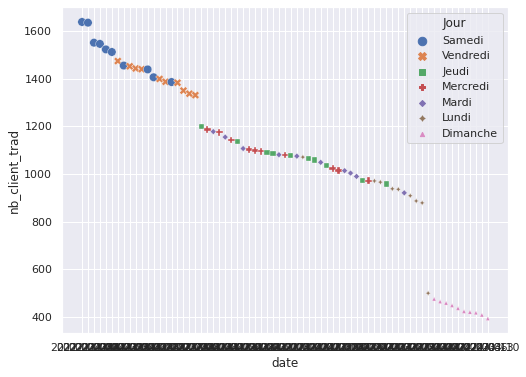

-----------------------------------------------

-----------------     8     -----------------
----        Market Cany-Barville      ------------


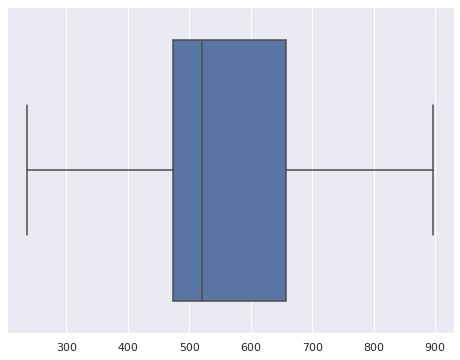

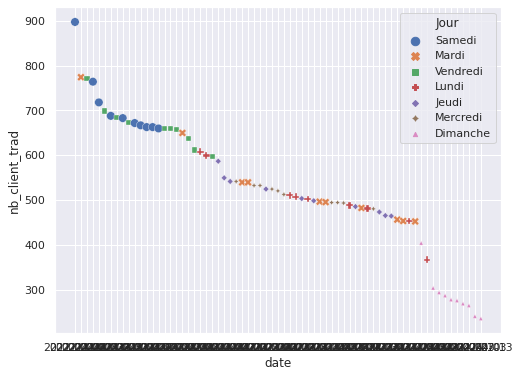

-----------------------------------------------

-----------------     9     -----------------
----        Market Sotteville-Les-Rouen      ------------


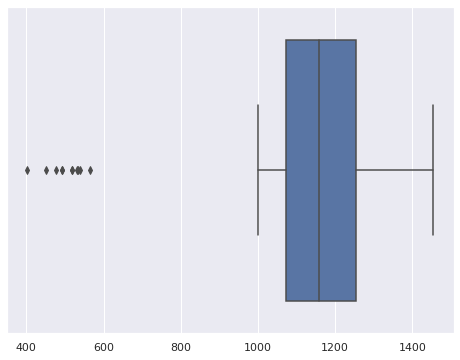

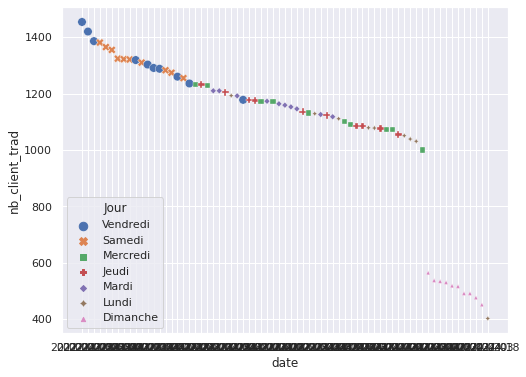

-----------------------------------------------



In [51]:
import warnings
warnings.filterwarnings("ignore")

sns.set(rc ={'figure.figsize':(8,6)})
#for i in range(0,len(list_anabel)):
for i in range(0,10):
  print("-----------------    ",i,"    -----------------")
  print("----       ",passageClient[passageClient['stoAnabelKey'] == list_anabel[i]]["Magasin"].values[0],"     ------------")
  magasinPassageCleint = passageClient[passageClient['stoAnabelKey'] == list_anabel[i]]
  plt.figure()
  sns.boxplot(sorted(magasinPassageCleint['nb_client_trad']))
  plt.show()
  plt.figure()
  sns.scatterplot (x=magasinPassageCleint["date"], y=magasinPassageCleint['nb_client_trad'], hue=magasinPassageCleint['Jour'],style=magasinPassageCleint['Jour'],size=magasinPassageCleint['Jour'])
  plt.show()
  print("-----------------------------------------------")
  print("")



## 1. UNIVARIATE SCATTER PLOT :


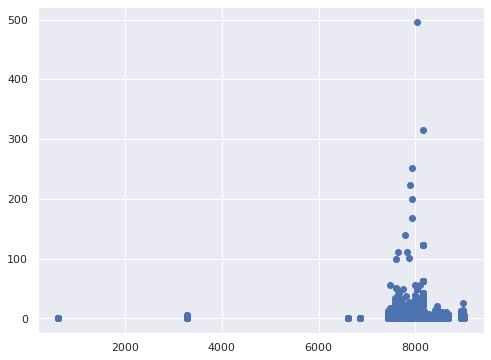

In [52]:
plt.scatter(BDDtmp["stoanabelkey"],BDDtmp['attente_en_caisse'])
plt.show()

## Box Plot :

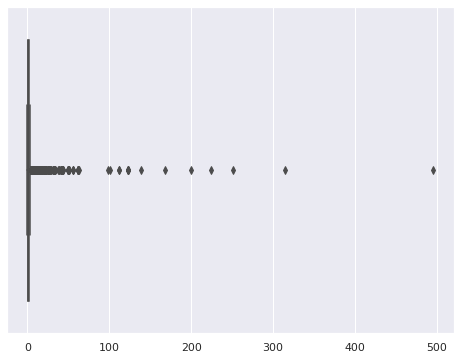

In [53]:
sns.boxplot(sorted(BDDtmp['attente_en_caisse']))

- we can notice that there are many outliers (500,300,200...), we can easily say that these are wrong values according to what it refers to ( the number of people in the line or the "waiting queue" ).

- Much of the debate on how to deal with outliers in data comes down to the following question: Should you keep outliers, remove them, or change them to another variable?


- In our case we can't keep these outliers because some of these doesn't have a meaning lile (200,300,500...) so we are going to delete these values and well keep just the meaningful values [0 - 10].

In [54]:
#define outliers to delete in the column (attente_en_caisse)
max_outlier = 10
indexes = BDDtmp[BDDtmp.attente_en_caisse > max_outlier].index
BDDtmp.drop(indexes, axis=0, inplace=True)


- There are also NAN values in our dataframe that won't be usefull in our study, so, we are going to delete the lines that contains NAN values.

In [55]:
#delete the NAN values in the column (attente_en_caisse)
BDDtmp.dropna(subset= ["attente_en_caisse"],inplace=True)
sorted(BDDtmp['attente_en_caisse'].unique())

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

- Recheck our BoxPlot and outliers :

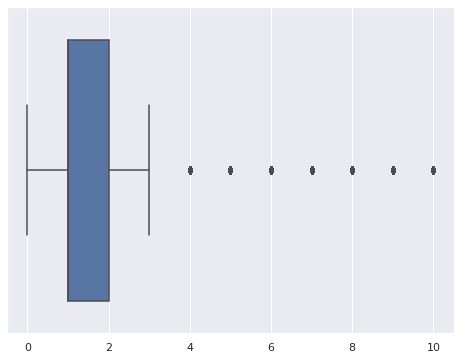

In [56]:
sns.boxplot(sorted(BDDtmp['attente_en_caisse']))

- we still have some outliers that represent all the values greater than 3. But we still don't know how much reprensent each one, in that case we will try to find its number of occurence.

In [57]:
BDDtmp['attente_en_caisse'].value_counts()

1.0     587408
2.0     359790
0.0     241040
3.0      39191
4.0       3003
5.0        554
6.0        242
7.0        144
8.0         76
9.0         48
10.0        26
Name: attente_en_caisse, dtype: int64

- In a period of 4 months we can see that we have a very small number of occurence of the waiting queue between 5-10 and we see that also in the boxplot. this number increase with an exponencial power down to 0,1,2, but these values still has a meaning so we can't delete it directly. 

- we can replace these lines and keep only the values of 0,1,2 and 3+. the 3+ will contain all the values greater than 3.

In [58]:
#put all values of attente_en_caisse where >3 in 3+ attente_en_caisse
BDDtmp.loc[BDDtmp.attente_en_caisse > 3, "attente_en_caisse"] = 3
BDDtmp['attente_en_caisse'].value_counts()


1.0    587408
2.0    359790
0.0    241040
3.0     43284
Name: attente_en_caisse, dtype: int64

Double check our BoxPlot :

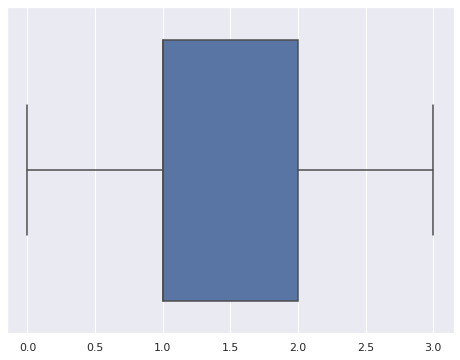

In [59]:
sns.boxplot(sorted(BDDtmp['attente_en_caisse']))

## Scoring :

In [62]:
top_scoring = 100

### Scoring 1: 

In [63]:
BDDtmp.loc[BDDtmp.attente_en_caisse == 0, "Scoring"] = 3
BDDtmp.loc[BDDtmp.attente_en_caisse == 1, "Scoring"] = 2
BDDtmp.loc[BDDtmp.attente_en_caisse == 2, "Scoring"] = 1
BDDtmp.loc[BDDtmp.attente_en_caisse == 3, "Scoring"] = 0
BDDtmp['Scoring'].value_counts()

2.0    587408
1.0    359790
3.0    241040
0.0     43284
Name: Scoring, dtype: int64

In [64]:
BDDtmp[["stodisplaydesc","stoanabelkey","Scoring"]].groupby(["stodisplaydesc","stoanabelkey"]).sum().sort_values(by=['Scoring'], ascending=False).head(top_scoring)

,,Scoring
stodisplaydesc,stoanabelkey,
PARIS -SEINE,7582,12326.0
ST MAURICE,7809,12311.0
MILLY LA FORET,7879,11440.0
BORDEAUX -ST JEAN,7728,11036.0
FONTENAY AUX ROSES,7575,10996.0
...,...,...
BLAINVILLE S/MER,8080,8319.0
AUCHEL -GANDHI,7828,8309.0
MARLY,7876,8308.0


### Scoring 2:

In [65]:
score_attente_0 = 5
score_attente_1 = 2
score_attente_2 = 0
score_attente_3_et_plus = -5

In [68]:
link2 = "/content/drive/MyDrive/PFE/Attente Dec-Avril.csv"
attente                = pd.read_csv(link2, sep=",")
attente.sort_values(by=['creationDate'], ascending=False)
attente["Scoring"]=0.0
#-------------------------------------------------------------------------------
#----------------------       date format   ------------------------------------
from datetime import datetime
for k in range(0,len(attente[['Magasin']])):
  date = datetime.strptime(str(attente.at[k, "creationDate"]),'%d %b %Y')	
  date = datetime.strptime(str(date),"%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d")
  attente.at[k, "creationDate"] = date
#----------------------       update date   ------------------------------------
attente.sort_values(by=['creationDate'], ascending=False)
#----------------------       scoring 2     ------------------------------------
attente["Scoring"] = attente["Taux_0"]*score_attente_0+attente["Taux_1"]*score_attente_1+attente["Taux_2"]*score_attente_2+attente["Taux_3"]*score_attente_3_et_plus
attente[["Magasin","Magasin (code Anabel)","Scoring"]].groupby(["Magasin","Magasin (code Anabel)"]).sum().sort_values(by=['Scoring'], ascending=False).head(top_scoring)

,,Scoring
Magasin,Magasin (code Anabel),
Market Le Touquet,7967,452.568554
Market Saint-Maurice,7809,400.548469
Market Neuville-Les-Dieppe Libération,7573,382.781453
Market Chartrettes,7824,373.680259
Market Estaires,7858,372.492759
...,...,...
Market Argelès Gazost,7613,191.948949
Market Ham,7785,191.410654
Market Clamart,7929,190.755989


### Scoring final( 1 & 2 ):

In [69]:
scoring1 = BDDtmp[["stodisplaydesc","stoanabelkey","Scoring"]].groupby(["stodisplaydesc","stoanabelkey"]).sum().sort_values(by=['Scoring'], ascending=False).head(top_scoring).reset_index()
scoring2 = attente[["Magasin","Magasin (code Anabel)","Scoring"]].groupby(["Magasin","Magasin (code Anabel)"]).sum().sort_values(by=['Scoring'], ascending=False).head(top_scoring).reset_index()
scoring_final= pd.merge(scoring1,scoring2,how='inner',left_on=['stoanabelkey'],right_on=['Magasin (code Anabel)'])
scoring_final[["stodisplaydesc","stoanabelkey","Scoring_x","Scoring_y"]]

,stodisplaydesc,stoanabelkey,Scoring_x,Scoring_y
0,ST MAURICE,7809,12311.0,400.548469
1,MILLY LA FORET,7879,11440.0,349.409734
2,BORDEAUX -ST JEAN,7728,11036.0,303.563613
3,FONTENAY AUX ROSES,7575,10996.0,366.630164
4,LE TOUQUET,7967,10953.0,452.568554
...,...,...,...,...
71,YUTZ,7924,8451.0,294.611705
72,BLAINVILLE S/MER,8080,8319.0,230.427344
73,AUCHEL -GANDHI,7828,8309.0,231.193461
74,MARLY,7876,8308.0,239.632013


## Scoring 3 : Picasso

In [70]:
link = "/content/drive/MyDrive/PFE/Picasso_14_10_2021_au_10_04_2022.csv"
picasso                = pd.read_csv(link, sep=",")
scoring3 = picasso[["Magasin","stoanabelkey","Redondance"]].groupby(["Magasin","stoanabelkey"]).sum().sort_values(by=['Redondance'], ascending=False).tail(top_scoring).reset_index()
scoring_final_2= pd.merge(scoring1,scoring3,how='inner',left_on=['stoanabelkey'],right_on=['stoanabelkey'])
scoring3.sort_values("Redondance").reset_index()[["Magasin","stoanabelkey","Redondance"]]

,Magasin,stoanabelkey,Redondance
0,MASSY -GD OUEST,6604,0
1,TOULOUSE -COMPANS,7524,2
2,PARIS -ST MARCEL,7583,2
3,BEAURAINS -BOREAL,9002,3
4,PLOUHINEC,7522,3
...,...,...,...
95,BUCHY,7649,51
96,ST CALAIS -PRESSOIR,8954,51
97,ESSARS,7953,51
98,ESTAIRES,7858,52


In [71]:
scoring_final_2.sort_values("Redondance").reset_index()[["Magasin","stoanabelkey","Redondance"]]

,Magasin,stoanabelkey,Redondance
0,PLOUHINEC,7522,3
1,ST PIERRE D'IRUBE,8456,3
2,BEAURAINS -BOREAL,9002,3
3,PONT EVEQUE,8045,4
4,LE TOUQUET,7967,5
5,NICE -MONT BORON,7886,6
6,ENNERY,8622,6
7,ALENCON -QUAKENBRUCK,7596,7
8,TOULOUSE -JOLIMONT,7719,8
9,BRIANCON,8285,8


# Correlation :


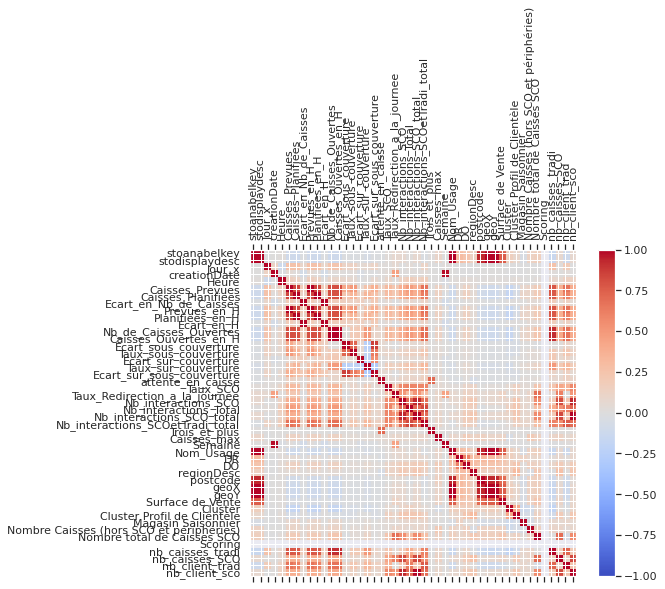

In [73]:
corr = BDD.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(BDD.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(BDD.columns)
ax.set_yticklabels(BDD.columns)
plt.show()

- If we take a look on our correlation plot wi can easily notice that there are many correlated variables such as **(geoX - anabelstokey),(geoY - anabelstokey),(stodisplaydesc - anabelstokey),(Caisse_Prevues -Prevues_en_h) ,(Semaine - creationDate)** etc.



#Data collection :

## X_train , Y_train : 

In [ ]:
# caisse_max = BDD[['stodisplaydesc',"Nombre Caisses (hors SCO et périphéries)","Nombre total de Caisses SCO"]].groupby(["stodisplaydesc"]).max().sort_values(by=['Nombre Caisses (hors SCO et périphéries)'], ascending=False).reset_index()
# #caisse_max = BDD.groupby(["stodisplaydesc","stoAnabelKey","Magasin","Jour"]).sum().sort_values(by=['nb_caisses_tradi'], ascending=False).reset_index()
# cmp=0
# for row in caisse_max.iterrows():
#   cmp+=1
#   print("--------",cmp,"-----------")
#   print(row[1][0],'  |  ',row[1][1],': Caisses hors periph  |  ',row[1][2],": Caisses SCO")
  

In [74]:
BDD = BDD.astype({"Nombre Caisses (hors SCO et périphéries)": int})
caisse_max1 = BDD[['stodisplaydesc','Nombre Caisses (hors SCO et périphéries)','Nombre total de Caisses SCO']].groupby(["stodisplaydesc"]).mean().sort_values(by=['Nombre Caisses (hors SCO et périphéries)'], ascending=False).reset_index()
caisse_max1


,stodisplaydesc,Nombre Caisses (hors SCO et périphéries),Nombre total de Caisses SCO
0,SARLAT -BRIVE,20.0,4.0
1,EPINAY S/ORGE,20.0,8.0
2,PERTUIS,18.0,3.0
3,BRIANCON,18.0,0.0
4,NANTEUIL LES M -FOUL,18.0,4.0
...,...,...,...
256,ST GERMAIN EN LAYE,5.0,4.0
257,PARIS -PROCESSION,5.0,4.0
258,SETE,5.0,4.0
259,BOURBOURG,4.0,2.0


In [77]:
#identification the training dataset X
X = BDD.loc[BDD['stoanabelkey'].isin(scoring_final_2.stoanabelkey.values)].reset_index()

X = X.drop(columns=['index',
                    'stodisplaydesc',
                    'Scoring',
                    'Caisses_max',
                    'Nombre total de Caisses SCO',
                    'creationDate',
                    'Heure',
                    'Nom_Usage',
                    'DR',
                    'DO',
                    'Nb_interactions_SCO_total',
                    'Nb_interactions_SCOetTradi_total',
                    'Ecart_en_Nb_de_Caisses',
                    'Prevues_en_H',
                    'Planifiees_en_H',
                    'Caisses_Ouvertes_en_H',
                    'Ecart_en_H',
                    'Ecart_sous_couverture',
                    'Taux_sous_couverture',
                    'Ecart_sur_couverture',
                    'Taux_sur_couverture',
                    'Ecart_sur_sous_couverture',
                    'Taux_SCO',
                    'Taux_Redirection_a_la_journee'])
#Jour in numbers
X = X.replace("Lundi", 1)
X = X.replace("Mardi", 2)
X = X.replace("Mercredi", 3)
X = X.replace("Jeudi", 4)
X = X.replace("Vendredi", 5)
X = X.replace("Samedi", 6)
X = X.replace("Dimanche", 7)

X = X.replace("DEI HORS PARIS INTRA", 1)
X = X.replace("PARIS INTRAMUROS", 2)
#drop NA
X = X.dropna()

Y_train = X["Nombre Caisses (hors SCO et périphéries)"]
X_train = X.drop(columns=["Nombre Caisses (hors SCO et périphéries)"])
X_train


,stoanabelkey,Jour_x,Caisses_Prevues,Caisses_Planifiees,Nb_de_Caisses_Ouvertes,attente_en_caisse,Nb_interactions_SCO,Nb_interactions_Total,Trois_et_plus,Semaine,...,geoX,geoY,Surface de Vente,Cluster,Cluster Profil de Clientèle,Magasin Saisonnier,nb_caisses_tradi,nb_caisses_SCO,nb_client_trad,nb_client_sco
0,8285,1,1,2,2,0.0,0,7,0.0,7,...,6.624402,44.881284,000004080,5,1,1,2.0,0.0,8.0,0.0
1,7861,1,1,2,3,0.0,1,4,0.0,7,...,5.463294,43.466698,000002600,5,1,0,2.0,1.0,3.0,1.0
2,7882,1,1,1,1,0.0,0,6,0.0,7,...,6.988000,43.605200,000001168,3,1,0,1.0,0.0,6.0,0.0
3,7633,1,1,1,1,0.0,0,5,0.0,7,...,7.287960,43.741840,000001500,3,4,0,1.0,0.0,7.0,0.0
4,7653,1,1,1,1,1.0,0,4,0.0,7,...,5.228803,43.492139,000002508,3,1,0,1.0,0.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64304,7719,7,2,5,5,0.0,0,5,0.0,12,...,1.466059,43.613337,000001570,1,3,0,5.0,0.0,8.0,0.0
64305,7570,7,1,4,3,0.0,0,1,0.0,12,...,0.059376,49.351662,000001715,2,3,1,3.0,0.0,4.0,0.0
64306,7820,7,10,11,8,0.0,0,2,0.0,12,...,2.055344,48.756467,000003647,3,1,0,8.0,0.0,11.0,0.0
64307,7735,7,3,6,4,0.0,3,7,0.0,12,...,-0.572810,44.834920,000002200,1,3,0,3.0,2.0,8.0,4.0


## X_test, Y_test : 

In [78]:
list_anabel_train = list(scoring_final_2['stoanabelkey'].values)
list_anabel = list(BDD.stoanabelkey.unique())
list_anabel_test = [x for x in list_anabel if x not in list_anabel_train]

In [79]:

#identification the training dataset X
X = BDD.loc[BDD['stoanabelkey'].isin(list_anabel_test)].reset_index()
X = X.drop(columns=['index',
                    'stodisplaydesc',
                    'Scoring',
                    'Caisses_max',
                    'Nombre total de Caisses SCO',
                    'creationDate',
                    'Heure',
                    'Nom_Usage',
                    'DR',
                    'DO',
                    'Nb_interactions_SCO_total',
                    'Nb_interactions_SCOetTradi_total',
                    'Ecart_en_Nb_de_Caisses',
                    'Prevues_en_H',
                    'Planifiees_en_H',
                    'Caisses_Ouvertes_en_H',
                    'Ecart_en_H',
                    'Ecart_sous_couverture',
                    'Taux_sous_couverture',
                    'Ecart_sur_couverture',
                    'Taux_sur_couverture',
                    'Ecart_sur_sous_couverture',
                    'Taux_SCO',
                    'Taux_Redirection_a_la_journee'])

X = X.replace("Lundi", 1)
X = X.replace("Mardi", 2)
X = X.replace("Mercredi", 3)
X = X.replace("Jeudi", 4)
X = X.replace("Vendredi", 5)
X = X.replace("Samedi", 6)
X = X.replace("Dimanche", 7)

X = X.replace("DEI HORS PARIS INTRA", 1)
X = X.replace("PARIS INTRAMUROS", 2)
X = X.replace("DE EST", 3)
X = X.replace("DE OUEST", 4)

X.dropna(how='any', inplace=True)
X = X.dropna()

Y_test = X["Nombre Caisses (hors SCO et périphéries)"]
X_test = X.drop(columns=['Nombre Caisses (hors SCO et périphéries)'])

X_test

,stoanabelkey,Jour_x,Caisses_Prevues,Caisses_Planifiees,Nb_de_Caisses_Ouvertes,attente_en_caisse,Nb_interactions_SCO,Nb_interactions_Total,Trois_et_plus,Semaine,...,geoX,geoY,Surface de Vente,Cluster,Cluster Profil de Clientèle,Magasin Saisonnier,nb_caisses_tradi,nb_caisses_SCO,nb_client_trad,nb_client_sco
0,8627,1,1,1,1,0.0,0,5,0.0,7,...,6.957747,43.551019,000003000,5,1,0,1.0,0.0,5.0,0.0
1,7709,1,1,1,1,0.0,0,4,0.0,7,...,4.699370,45.258550,000002469,5,1,0,1.0,0.0,5.0,0.0
2,7998,1,1,1,1,1.0,0,4,0.0,7,...,3.607831,43.430043,000001848,4,1,0,1.0,0.0,4.0,0.0
3,7634,1,1,3,2,0.0,0,4,0.0,7,...,5.499406,43.681206,000004845,5,1,0,2.0,0.0,4.0,0.0
4,7907,1,1,1,1,0.0,0,1,0.0,7,...,4.198461,44.250579,000001978,4,1,1,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235411,7918,7,2,5,3,1.0,0,7,0.0,12,...,2.183220,48.784890,000000958,1,3,0,3.0,0.0,8.0,0.0
235412,7742,7,2,8,5,1.0,3,6,0.0,12,...,1.071000,47.805000,000002775,5,1,0,4.0,2.0,6.0,3.0
235413,7920,7,5,7,6,1.0,1,7,0.0,12,...,2.157310,48.802950,000001651,3,2,0,5.0,1.0,13.0,1.0
235414,7730,7,4,5,4,0.0,3,10,0.0,12,...,2.452771,48.847611,000001453,1,2,0,3.0,3.0,10.0,3.0


 ## Kmeans:

In [80]:
X_train

,stoanabelkey,Jour_x,Caisses_Prevues,Caisses_Planifiees,Nb_de_Caisses_Ouvertes,attente_en_caisse,Nb_interactions_SCO,Nb_interactions_Total,Trois_et_plus,Semaine,...,geoX,geoY,Surface de Vente,Cluster,Cluster Profil de Clientèle,Magasin Saisonnier,nb_caisses_tradi,nb_caisses_SCO,nb_client_trad,nb_client_sco
0,8285,1,1,2,2,0.0,0,7,0.0,7,...,6.624402,44.881284,000004080,5,1,1,2.0,0.0,8.0,0.0
1,7861,1,1,2,3,0.0,1,4,0.0,7,...,5.463294,43.466698,000002600,5,1,0,2.0,1.0,3.0,1.0
2,7882,1,1,1,1,0.0,0,6,0.0,7,...,6.988000,43.605200,000001168,3,1,0,1.0,0.0,6.0,0.0
3,7633,1,1,1,1,0.0,0,5,0.0,7,...,7.287960,43.741840,000001500,3,4,0,1.0,0.0,7.0,0.0
4,7653,1,1,1,1,1.0,0,4,0.0,7,...,5.228803,43.492139,000002508,3,1,0,1.0,0.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64304,7719,7,2,5,5,0.0,0,5,0.0,12,...,1.466059,43.613337,000001570,1,3,0,5.0,0.0,8.0,0.0
64305,7570,7,1,4,3,0.0,0,1,0.0,12,...,0.059376,49.351662,000001715,2,3,1,3.0,0.0,4.0,0.0
64306,7820,7,10,11,8,0.0,0,2,0.0,12,...,2.055344,48.756467,000003647,3,1,0,8.0,0.0,11.0,0.0
64307,7735,7,3,6,4,0.0,3,7,0.0,12,...,-0.572810,44.834920,000002200,1,3,0,3.0,2.0,8.0,4.0


In [81]:
n_clusters = len(sorted(list(Y_train.unique())))
#sorted(list(Y_test.unique()))
n_clusters

13

In [82]:
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X_train)
y_kmeans = kmeans.predict(X_test)

In [83]:
from sklearn.metrics.cluster import adjusted_rand_score
score = adjusted_rand_score(Y_test,y_kmeans)
score

0.036295359821011265

In [84]:
#caisse_max = BDD[['stodisplaydesc',"Nombre Caisses (hors SCO et périphéries)","Nombre total de Caisses SCO"]].groupby(["stodisplaydesc"]).max().sort_values(by=['Nombre Caisses (hors SCO et périphéries)'], ascending=False).reset_index()
#caisse_max = BDD.groupby(["stodisplaydesc","stoAnabelKey","Magasin","Jour"]).sum().sort_values(by=['nb_caisses_tradi'], ascending=False).reset_index()
result =[]
X_test = X_test["stoanabelkey"].reset_index()
X_test = X_test.drop(columns=['index'])

cmp=0
for row in Y_test:
  result.append([X_test["stoanabelkey"][cmp],row,  y_kmeans[cmp]])
  cmp+=1

In [85]:
result

[[8627, 12, 5],
 [7709, 10, 5],
 [7998, 8, 4],
 [7634, 18, 2],
 [7907, 10, 12],
 [8469, 12, 1],
 [8627, 12, 5],
 [7996, 8, 4],
 [7634, 18, 2],
 [7907, 10, 12],
 [8469, 12, 1],
 [7826, 10, 2],
 [7639, 10, 2],
 [7469, 11, 11],
 [7613, 11, 8],
 [7941, 7, 8],
 [7618, 12, 10],
 [7942, 10, 8],
 [7943, 8, 8],
 [8076, 5, 0],
 [7657, 10, 6],
 [8427, 9, 1],
 [7612, 14, 12],
 [7658, 5, 8],
 [7619, 10, 2],
 [8010, 14, 8],
 [7971, 12, 0],
 [7616, 8, 4],
 [7737, 8, 0],
 [7772, 12, 6],
 [8627, 12, 5],
 [7848, 12, 6],
 [8017, 7, 9],
 [7631, 12, 8],
 [7720, 9, 4],
 [7724, 10, 0],
 [8019, 8, 8],
 [7677, 12, 0],
 [7776, 15, 7],
 [7709, 10, 5],
 [7518, 6, 9],
 [7856, 7, 3],
 [7777, 20, 6],
 [7953, 10, 8],
 [7859, 11, 0],
 [7439, 10, 9],
 [8089, 14, 9],
 [7620, 9, 8],
 [7981, 8, 8],
 [7785, 8, 2],
 [7982, 10, 0],
 [8025, 10, 8],
 [8026, 7, 11],
 [7786, 7, 0],
 [7787, 6, 6],
 [7609, 8, 7],
 [7688, 8, 9],
 [7788, 8, 0],
 [7689, 9, 11],
 [7996, 8, 4],
 [7862, 11, 7],
 [7531, 8, 7],
 [7902, 8, 7],
 [8153, 7, 7

# Iris

In [ ]:
# from sklearn.metrics import pairwise_distances_argmin
# def find_clusters(X, n_clusters, rseed=2):
#     # 1. Randomly choose clusters
#     rng = np.random.RandomState(rseed)
#     i = rng.permutation(X.shape[0])[:n_clusters]
#     centers = X[i]
    
#     while True:
#         # 2a. Assign labels based on closest center
#         labels = pairwise_distances_argmin(X, centers)
        
#         # 2b. Find new centers from means of points
#         new_centers = np.array([X[labels == i].mean(0)
#                                 for i in range(n_clusters)])
        
#         # 2c. Check for convergence
#         if np.all(centers == new_centers):
#             break
#         centers = new_centers
    
#     return centers, labels

# centers, labels = find_clusters(X, 4)
# plt.scatter(X[:, 0], X[:, 1], c=labels,
#             s=50, cmap='viridis');

In [ ]:
# !pip install qwikidata
# !pip install pycountry

# import qwikidata
# import qwikidata.sparql

# def get_city_wikidata(city, country):
#     query = """
#     SELECT ?city ?cityLabel ?country ?countryLabel ?population
#     WHERE
#     {
#       ?city rdfs:label '%s'@en.
#       ?city wdt:P1082 ?population.
#       ?city wdt:P17 ?country.
#       ?city rdfs:label ?cityLabel.
#       ?country rdfs:label ?countryLabel.
#       FILTER(LANG(?cityLabel) = "en").
#       FILTER(LANG(?countryLabel) = "en").
#       FILTER(CONTAINS(?countryLabel, "%s")).
#     }
#     """ % (city, country)

#     res = qwikidata.sparql.return_sparql_query_results(query)
#     out = res['results']['bindings'][0]
#     return out

# get_city_wikidata('Paris', 'France')